# Spike - Recurrent Neural Netork

-- more descriptions will be added --

## Imports and CoLab checking
In this section first we check if this code is running in the Google CoLab or in a Local Jupiter Notebook.
Afterwad, the proper libraries will be imported.

In [1]:
import sys, os
IN_COLAB = 'google.colab' in sys.modules
print 'Colab:', IN_COLAB

Colab: False


In [2]:
if IN_COLAB:
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    # Authenticate and create the PyDrive client.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    
    from google.colab import drive
    drive.mount('/content/drive')
    DATASET_FOLDER_PATH = "/content/drive/My Drive/ColabCodes/data/"
else:
    DATASET_FOLDER_PATH = "/Users/aref/dvs-dataset/"
    
if not os.path.exists(DATASET_FOLDER_PATH):
    raise Exception('can not access data folder.')

In [3]:
# numpy essentials imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split

# py-torch required imports
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from torch.autograd import Variable

# misc imports
from time import sleep, time

## Reading Dataset
This section is for reading the cached dataset from the defined path.

In [4]:
# mapping
gesture_mapping = {
    0: 'no_gesture',
    1: 'hand_clapping',
    2: 'right_hand_wave',
    3: 'left_hand_wave',
    4: 'right_arm_clockwise',
    5: 'right_arm_counter_clockwise',
    6: 'left_arm_clockwise',
    7: 'left_arm_counter_clockwise',
    8: 'arm_roll',
    9: 'air_drums',
    10: 'air_guitar',
    11: 'other_gestures',
}


In [5]:
def load_trail_files(trail_file):
    file_list = []
    with open(os.path.join(DATASET_FOLDER_PATH, 'DvsGesture', trail_file), 'r') as f:
        for line in f.readlines():
            aedat_file = line.strip()
            if not line:
                continue
            csv_file = aedat_file.replace('.aedat', '_labels.csv')
            file_list.append((
                os.path.join(DATASET_FOLDER_PATH, aedat_file),
                os.path.join(DATASET_FOLDER_PATH, csv_file)
            ))
    return file_list

def data_loader(trail, condition_limit=None):
    dataset_path = DATASET_FOLDER_PATH + 'cleaned_cache_' + trail
    file_list = load_trail_files('trials_to_%s.txt' % trail)

    
    for counter, f in enumerate(file_list):
        # FIXME: This line is not satisfactory...
        light_condition = f[0].split('/')[-1].split('.')[0][len('userXX_'):]
        if condition_limit is not None and light_condition not in condition_limit:
            continue
        
        x_data = np.load(file='%s/x_%s_%d.npy' % (dataset_path, trail, counter+1))
        y_data = np.load(file='%s/y_%s_%d.npy' % (dataset_path, trail, counter+1))
        
        yield x_data, y_data

In [6]:
from random import randint

def serialize_events(x_data, y_data, shuffle_augmentation=None, sequential_augmentation=True):
    total_data_frame_count = x_data.shape[0]
    
    x_batch = []
    y_batch = []
    
    x_instance = []
    y_instance = None
    
    if sequential_augmentation:
        for i in range(total_data_frame_count):
            x_instance.append(x_data[i, ...])
            if y_instance is None:
                y_instance = y_data[i]
            elif y_instance != y_data[i]:
                x_instance = []
                y_instance = None
                continue

            if len(x_instance) == FRAMES_COUNT and y_instance != 0:
                x_batch.append(np.array(x_instance))
                y_batch.append(y_instance)

                x_instance = []
                y_instance = None

                if len(x_batch) == BATCH_SIZE:
                    yield np.array(x_batch), np.array(y_batch)
                    x_batch = []
                    y_batch = []

    if shuffle_augmentation is not None:
        x_instance = []
        y_instance = None

        augmented_batchs = 0
        while augmented_batchs < shuffle_augmentation:
            start = randint(0, total_data_frame_count-FRAMES_COUNT-1)
            
            for i in range(start, start+FRAMES_COUNT):
                x_instance.append(x_data[i, ...])
                if y_instance is None:
                    y_instance = y_data[i]
                elif y_instance != y_data[i]:
                    break
            
            if len(x_instance) == FRAMES_COUNT and y_instance != 0:
                x_batch.append(np.array(x_instance))
                y_batch.append(y_instance)

                if len(x_batch) == BATCH_SIZE:
                    augmented_batchs += 1
                    yield np.array(x_batch), np.array(y_batch)
                    x_batch = []
                    y_batch = []
            
            x_instance = []
            y_instance = None

In [7]:
%matplotlib inline

def visualize_dataset():
    ev_times = z_data[:, 1]
    frames = 0
    max_time = np.max(ev_times)
    current_time = np.min(ev_times)
    while (current_time < max_time):
        ev_lb = ev_times > current_time
        ev_ub = ev_times < (current_time + FRAME_LENGTH_US)

        event_x = x_data[ev_lb & ev_ub, :]
        event_y = y_data[ev_lb & ev_ub]

        retina = np.zeros([128, 128])
        retina[event_x[:,1], event_x[:,0]] = 1

        frame_y = gesture_mapping[np.round(np.median(event_y))]

        plt.imshow(retina)
        plt.title(frame_y)
        plt.show()
        plt.pause(0.2)

        frames += 1
        if frames > 15:
            break

        current_time += FRAME_LENGTH_US


# visualize_dataset()

## Network Architechture & Tools

In [8]:
dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    print('using cuda...')
    device = torch.device("cuda")     
else:
    print('using cpu...')
    device = torch.device("cpu")

using cpu...


In [9]:
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_SIZE  = IMAGE_HEIGHT*IMAGE_WIDTH

NUM_HIDDEN_UNITS  = 128
NUM_OUTPUT = 12

FRAMES_COUNT  = 60
BATCH_SIZE = 16

FRAME_LENGTH_US = 1 * 1000
USE_RECURRENT_NEURONS = False

time_step = FRAME_LENGTH_US / 1e6

LIGHT_CONDITION_LIMIT=['natural']
SHUFFLE_AUGMENTATION = 20

In [10]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

In [11]:
class SuperSpike(torch.autograd.Function):
    scale = 50.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        return grad_input/(SuperSpike.scale*torch.abs(input)+1.0)**2
#         return grad_input
    
spike_fn  = SuperSpike.apply

In [12]:
def compute_classification_accuracy(x_data, y_data):
    global hmap
    """ Computes classification accuracy on supplied data in batches. """
    accs = []
    for x_local, y_local in serialize_events(x_data, y_data):
        x_local = torch.from_numpy(x_local).type(dtype).to(device)
        y_local = torch.from_numpy(y_local.astype(np.long)).to(device)
        output, _ = run_snn(x_local)
        m, _ = torch.max(output,1) # max over time
        _, am = torch.max(m,1)      # argmax over output units
        tmp = np.mean((y_local.type(torch.long)==am).detach().cpu().numpy()) # compare to labels
        
        for i in range(y_local.shape[0]):
            hmap[y_local[i], am[i]] += 1
        accs.append(tmp)
    return np.mean(accs)


In [13]:
def print_accuracy_values():
    errors = []
    for x_data, y_data in data_loader('train', condition_limit=LIGHT_CONDITION_LIMIT):
        errors.append(compute_classification_accuracy(x_data, y_data))
    print("Train accuracy: %.3f" % (np.mean(np.array(errors))))

    errors = []
    for x_data, y_data in data_loader('test', condition_limit=LIGHT_CONDITION_LIMIT):
        errors.append(compute_classification_accuracy(x_data, y_data))
    print("Test accuracy: %.3f" % (np.mean(np.array(errors))))

In [14]:
from time import time
from datetime import datetime

_last_time_length = None
_iteration_left = None

def time_unit_creator(l_time):
    time_unit = 'seconds'
    if l_time >= 60:
        l_time /= 60
        time_unit = 'minutes'
    else:
        return l_time, time_unit
    
    if l_time >= 60:
        l_time /= 60
        time_unit = 'hours'
    else:
        return l_time, time_unit
    
    if l_time >= 24:
        l_time /= 24
        time_unit = 'days'
    else:
        return l_time, time_unit
        
    if l_time >= 30:
        l_time /= 30
        time_unit = 'month'
    else:
        return l_time, time_unit

def expector_timer(func):
    def wrapper(*args, **kwargs):
        global _last_time_length, _iteration_left
        t_start = time()
        
        if _last_time_length is not None:
            expectation = t_start
            if _iteration_left is not None:
                expectation +=  _last_time_length * _iteration_left
            else:
                expectation +=  _last_time_length
            datestr = datetime.fromtimestamp(expectation).strftime("%Y-%m-%d %H:%M:%S")
            print '[expecting to finish at %s]' % datestr
        res = func(*args, **kwargs)
        length = time() - t_start
        
        if _last_time_length is None:
            _last_time_length = length
        else:
            _last_time_length = .9 * _last_time_length + .1 * length
        
        length, length_unit = time_unit_creator(length)
        print '[operation finished at %s  -  took %d %s]' % (datetime.fromtimestamp(time()).strftime("%Y-%m-%d %H:%M:%S"), length, length_unit)
        
       
        return res
    return wrapper

In [15]:
%matplotlib inline
@expector_timer
def train_once():
    global loss_hist, hmap
    loss_hist = train(lr=2e-4, nb_epochs=5, loss_hist=loss_hist)

    plt.figure(figsize=(3.3,2),dpi=150)
    plt.plot(loss_hist)
    plt.plot(loss_hist_test, 'r--')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    sns.despine()
    print_accuracy_values()
    
    sns.heatmap(hmap)
    plt.show()
    hmap = np.zeros((NUM_OUTPUT, NUM_OUTPUT))
    
    if SAVE_CHECKPOINTS:
        np.save(file="checkpoints/_checkpoint_%d" % time(), arr=[w1, w2])
    print('[check point saved.]')

## Spike Simulation
Here is the code for simulating spikes as well as codes for training them.

In [16]:
def init_weights():
    global w1, w2, loss_hist, loss_hist_test, hmap
    weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

    w1 = torch.empty(((IMAGE_SIZE+1) if USE_RECURRENT_NEURONS else IMAGE_SIZE, NUM_HIDDEN_UNITS),  device=device, dtype=dtype, requires_grad=True)
    torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(IMAGE_SIZE))

    w2 = torch.empty((NUM_HIDDEN_UNITS, NUM_OUTPUT), device=device, dtype=dtype, requires_grad=True)
    torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(NUM_HIDDEN_UNITS))

    loss_hist = []
    loss_hist_test = []
    hmap = np.zeros((NUM_OUTPUT, NUM_OUTPUT))

    print('init')

init_weights()

init


In [17]:
def run_snn(inputs):    
    if USE_RECURRENT_NEURONS:
        h1 = torch.einsum("abc,cd->abd", (inputs, w1[:-1]))
    else:
        h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    hr = torch.zeros((BATCH_SIZE,NUM_HIDDEN_UNITS), device=device, dtype=dtype)
    syn = torch.zeros((BATCH_SIZE,NUM_HIDDEN_UNITS), device=device, dtype=dtype)
    mem = torch.zeros((BATCH_SIZE,NUM_HIDDEN_UNITS), device=device, dtype=dtype)

    mem_rec = [mem]
    spk_rec = [mem]

    # Compute hidden layer activity
    for t in range(FRAMES_COUNT):
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = torch.zeros_like(mem)
        c   = (mthr > 0)
        rst[c] = torch.ones_like(mem)[c]
       
        if USE_RECURRENT_NEURONS:
            rs =  torch.ones_like(mem)
            for i in range(BATCH_SIZE):
                rs[i,:] = w1[-1, :]
            rs[mthr <= 0] = 0.0
        else:
            rs = 0.0
        
        new_syn = alpha*syn +h1[:,t] +rs
        new_mem = beta*mem +syn -rst

        mem = new_mem
        syn = new_syn

        mem_rec.append(mem)
        spk_rec.append(out)

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((BATCH_SIZE,NUM_OUTPUT), device=device, dtype=dtype)
    out = torch.zeros((BATCH_SIZE,NUM_OUTPUT), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(FRAMES_COUNT):
#         rs = torch.ones_like(out)
#         for i in range(BATCH_SIZE):
#             rs[i,:] = w2[-1, :]
#         rs[out <= 0] = 0
        
        new_flt = alpha*flt +h2[:,t] #+rs
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [18]:
from random import random


def train(lr=2e-3, nb_epochs=10, loss_hist=None):
    params = [w1,w2]
    optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9,0.999))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()
    
    if loss_hist is None:
        loss_hist = []
    for e in range(nb_epochs):
        print_counter = 0
        local_loss = []
        test_local_loss = []
        for data_packet in data_loader('train', condition_limit=LIGHT_CONDITION_LIMIT):
            if print_counter % 4 == 0:
                print '.',
            print_counter += 1
            
            for x_data, y_data in serialize_events(*data_packet, shuffle_augmentation=SHUFFLE_AUGMENTATION):
                x_local = torch.from_numpy(x_data).type(dtype).to(device)
                y_local = torch.from_numpy(y_data.astype(np.long)).to(device)
                                
                output,_ = run_snn(x_local)
                m,_=torch.max(output,1)
                log_p_y = log_softmax_fn(m)
                loss_val = loss_fn(log_p_y, y_local)

                optimizer.zero_grad()
                loss_val.backward()
                optimizer.step()
                local_loss.append(loss_val.item())
                
        # this part is about drawing test plot
        for data_packet in data_loader('test', condition_limit=LIGHT_CONDITION_LIMIT):
            for x_data, y_data in serialize_events(*data_packet):
                if random() > 0.7:
                    continue
                    
                x_local = torch.from_numpy(x_data).type(dtype).to(device)
                y_local = torch.from_numpy(y_data.astype(np.long)).to(device)
                                
                output,_ = run_snn(x_local)
                m,_=torch.max(output,1)
                log_p_y = log_softmax_fn(m)
                loss_val = loss_fn(log_p_y, y_local)
                test_local_loss.append(loss_val.item())
        
        mean_loss = np.mean(local_loss)
        loss_hist.append(mean_loss)
        print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
        
        mean_loss = np.mean(test_local_loss)
        loss_hist_test.append(mean_loss)
    return loss_hist


init
. . . . Epoch 1: loss=2.61345
. . . . Epoch 2: loss=2.34754
. . . . Epoch 3: loss=2.29972
. . . . Epoch 4: loss=2.20896
. . . . Epoch 5: loss=2.13545


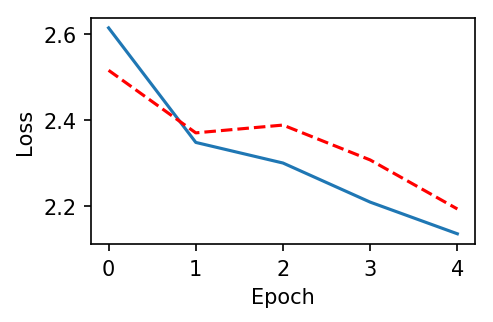

Train accuracy: 0.356
Test accuracy: 0.246


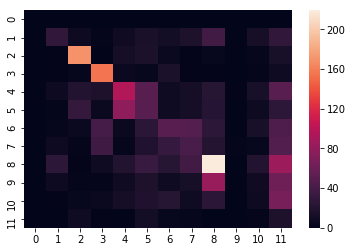

[check point saved.]
[operation finished at 2019-10-13 15:02:36  -  took 2 minutes]
[expecting to finish at 2019-10-13 15:25:17]
. . . . Epoch 1: loss=1.99415
. . . . Epoch 2: loss=1.75155
. . . . Epoch 3: loss=1.62139
. . . . Epoch 4: loss=1.30942
. . . . Epoch 5: loss=1.23826


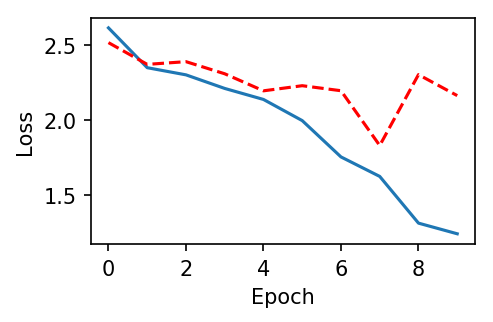

Train accuracy: 0.627
Test accuracy: 0.449


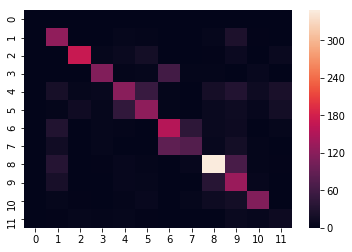

[check point saved.]
[operation finished at 2019-10-13 15:05:01  -  took 2 minutes]
[expecting to finish at 2019-10-13 15:25:06]
. . . . Epoch 1: loss=1.02136
. . . . Epoch 2: loss=0.95604
. . . . Epoch 3: loss=0.92053
. . . . Epoch 4: loss=0.79520
. . . . Epoch 5: loss=0.77012


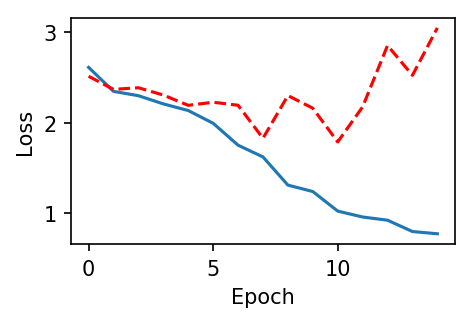

Train accuracy: 0.769
Test accuracy: 0.474


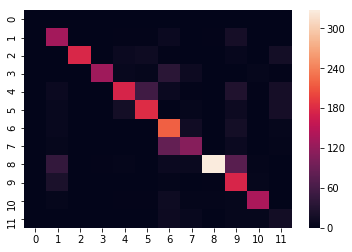

[check point saved.]
[operation finished at 2019-10-13 15:07:26  -  took 2 minutes]
[expecting to finish at 2019-10-13 15:24:56]
. . . . Epoch 1: loss=0.72063
. . . . Epoch 2: loss=0.62314
. . . . Epoch 3: loss=0.51998
. . . . Epoch 4: loss=0.49824
. . . . Epoch 5: loss=0.52177


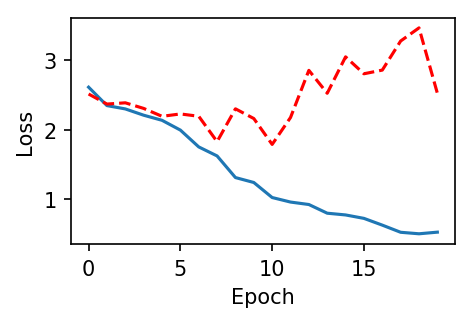

Train accuracy: 0.843
Test accuracy: 0.528


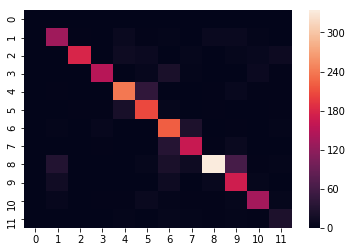

[check point saved.]
[operation finished at 2019-10-13 15:09:50  -  took 2 minutes]
[expecting to finish at 2019-10-13 15:24:48]
. . . . Epoch 1: loss=0.44493
. . . . Epoch 2: loss=0.38122
. . . . Epoch 3: loss=0.38914
. . . . Epoch 4: loss=0.29499
. . . . Epoch 5: loss=0.34368


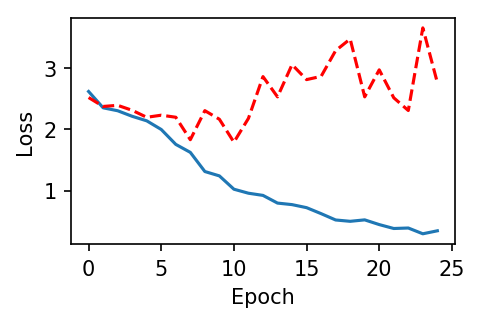

Train accuracy: 0.914
Test accuracy: 0.517


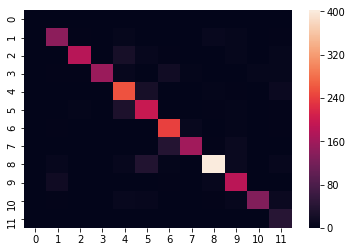

[check point saved.]
[operation finished at 2019-10-13 15:12:24  -  took 2 minutes]
[expecting to finish at 2019-10-13 15:24:54]
. . . . Epoch 1: loss=0.32305
. . . . Epoch 2: loss=0.28009
. . . . Epoch 3: loss=0.23475
. . . . Epoch 4: loss=0.17024
. . . . Epoch 5: loss=0.18556


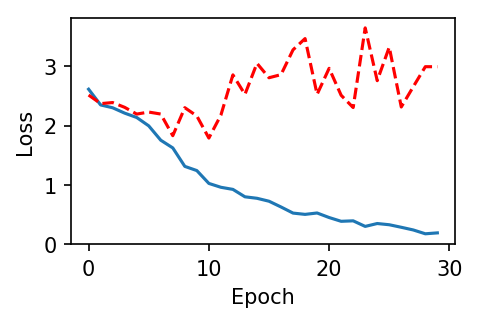

Train accuracy: 0.920
Test accuracy: 0.520


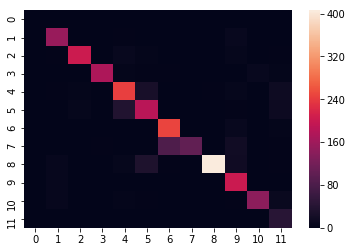

[check point saved.]
[operation finished at 2019-10-13 15:17:43  -  took 5 minutes]
[expecting to finish at 2019-10-13 15:28:50]
. . .

KeyboardInterrupt: 

In [19]:
SAVE_CHECKPOINTS = False

init_weights()
max_epoch_counter = 10
for i in range(max_epoch_counter):
    _iteration_left = max_epoch_counter - i
    train_once()

In [10]:
%matplotlib qt

from time import sleep
from random import randint

counter = 5
for data_packet in data_loader('train', condition_limit=LIGHT_CONDITION_LIMIT):
    for x_data, y_data in serialize_events(*data_packet):
        print x_data.shape, y_data.shape
        i = randint(0, 15)
        for f in range(FRAMES_COUNT):
            img = np.reshape(x_data[i, f, :], [64, 64])

            plt.figure(0)
            plt.imshow(img, cmap='gray', vmin=0, vmax=1)
            plt.show()
            plt.title('%d - %s' % (f, gesture_mapping[y_data[i]]))
            plt.pause(0.0001)
    #         sleep(0.05)
            plt.clf()
        counter -= 1
        if counter < 0:
            break
    if counter < 0:
        break

(16, 60, 4096) (16,)
(16, 60, 4096) (16,)
(16, 60, 4096) (16,)
(16, 60, 4096) (16,)
(16, 60, 4096) (16,)
(16, 60, 4096) (16,)


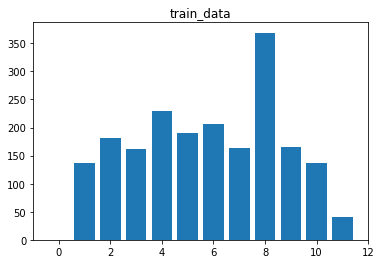

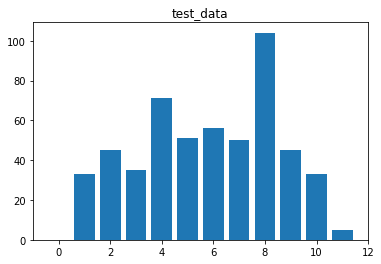

In [21]:
%matplotlib inline

l_counter = {i: 0 for i in range(12)}
for data_packet in data_loader('train', condition_limit=LIGHT_CONDITION_LIMIT):
    for x_data, y_data in serialize_events(*data_packet):
        for i in y_data:
            l_counter[i] += 1

plt.bar([i for i in range(12)], [l_counter[i] for i in range(12)])
plt.title('train_data')
plt.show()

l_counter = {i: 0 for i in range(12)}
for data_packet in data_loader('test', condition_limit=LIGHT_CONDITION_LIMIT):
    for x_data, y_data in serialize_events(*data_packet):
        for i in y_data:
            l_counter[i] += 1

plt.bar([i for i in range(12)], [l_counter[i] for i in range(12)])
plt.title('test_data')
plt.show()

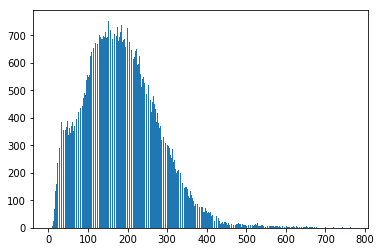

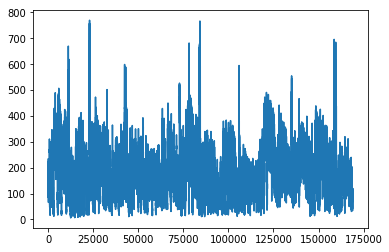

In [16]:
%matplotlib inline

from collections import defaultdict


spike_counter = defaultdict(lambda: 0)
spike_flow = []
for data_packet in data_loader('train', condition_limit=LIGHT_CONDITION_LIMIT):
    for x_data, y_data in serialize_events(*data_packet):
        for i in range(x_data.shape[0]):
            for f in range(x_data.shape[1]):
                c_frame = x_data[i, f, :]
                spc = np.count_nonzero(c_frame)
                spike_counter[spc] += 1
                spike_flow.append(spc)

n = max(spike_counter)
plt.bar([i for i in range(n)], [spike_counter[i] for i in range(n)])
plt.show()
plt.plot(spike_flow)
plt.show()

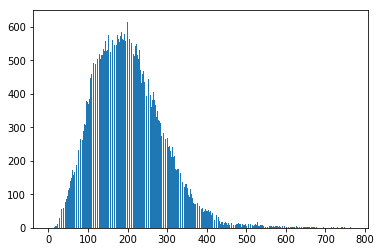

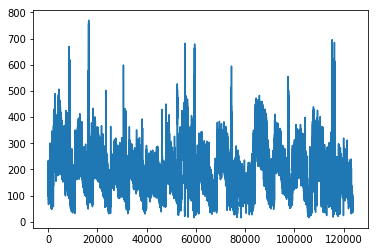

In [17]:
%matplotlib inline

from collections import defaultdict


spike_counter = defaultdict(lambda: 0)
spike_flow = []
for data_packet in data_loader('train', condition_limit=LIGHT_CONDITION_LIMIT):
    for x_data, y_data in serialize_events(*data_packet):
        for i in range(x_data.shape[0]):
            if y_data[i] == 0:
                continue
            for f in range(x_data.shape[1]):
                c_frame = x_data[i, f, :]
                spc = np.count_nonzero(c_frame)
                spike_counter[spc] += 1
                spike_flow.append(spc)

n = max(spike_counter)
plt.bar([i for i in range(n)], [spike_counter[i] for i in range(n)])
plt.show()
plt.plot(spike_flow)
plt.show()